In [2]:
import os
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../paper.mcstyle')

import seaborn as sns
import pandas as pd

import numpy as np
from scipy.stats import norm

import torch
import sbibm
import yaml
from tqdm import tqdm

In [3]:
cfgdir = './configs'
wdir = './slcp'

## Generate configurations

In [46]:
# create record csv

model_names = ['npe', 'nle', 'nre', 'snpe', 'snle', 'snre', 'mcabc']
Ns = [1_000, 10_000, 100_000]
obs = range(1,11)

rec = []
for i in obs:
    for m in model_names:
        for n in Ns:
            rec.append([
                m, n, i,
                f'./slcp/res/{m}_obs{i}_N{n}'
            ])
print(len(rec))


# Save as csv
df = pd.DataFrame(rec, columns=['model', 'N', 'obs', 'dir'])

filename = join(cfgdir, 'record.csv')
df.to_csv(filename, index=False)

filename = join(cfgdir, 'batch.csv')
df[['obs', 'N', 'model']].to_csv(filename, index=False, header=False)

df

180


,model,N,obs,dir
0,npe,1000,1,./slcp/res/npe_obs1_N1000
1,npe,10000,1,./slcp/res/npe_obs1_N10000
2,npe,100000,1,./slcp/res/npe_obs1_N100000
3,nle,1000,1,./slcp/res/nle_obs1_N1000
4,nle,10000,1,./slcp/res/nle_obs1_N10000
...,...,...,...,...
175,snle,10000,10,./slcp/res/snle_obs10_N10000
176,snle,100000,10,./slcp/res/snle_obs10_N100000
177,snre,1000,10,./slcp/res/snre_obs10_N1000
178,snre,10000,10,./slcp/res/snre_obs10_N10000


## Measure which have run

In [47]:
filename = join(cfgdir, 'record.csv')
record = pd.read_csv(filename)
record['done'] = False

for i, row in record.iterrows():
    record.loc[i, 'done'] = os.path.exists(join(row['dir'], 'single_samples.npy'))

In [48]:
print('len(record):', len(record))
record.groupby(['model','N'])['done'].sum()

len(record): 180


model  N     
nle    1000      10
       10000     10
       100000     7
npe    1000      10
       10000     10
       100000     4
nre    1000      10
       10000      9
       100000     7
snle   1000       0
       10000      0
       100000     0
snpe   1000       0
       10000      0
       100000     0
snre   1000       0
       10000      0
       100000     0
Name: done, dtype: int64

In [38]:
for i in tqdm(range(len(record))):
    row = record.loc[i]
    if row['done']:
        metrics = np.load(join(row['dir'], 'metrics.npy'), allow_pickle=True).item()
        record.loc[i, 'mmd'] = metrics['mmd']
        record.loc[i, 'c2st'] = metrics['c2st']

100%|██████████| 180/180 [00:00<00:00, 1968.78it/s]


In [40]:
rec = record.dropna(axis=0)
percs = rec.groupby(['model','N'])['mmd'].apply(np.percentile, [5,50,95])
percs

model  N     
nle    1000      [0.07932233810424805, 0.20775961875915527, 0.4...
       10000     [0.018198168277740477, 0.05915957689285278, 0....
       100000    [0.005232203006744385, 0.016737937927246094, 0...
npe    1000      [0.0731178879737854, 0.12627249956130981, 0.29...
       10000     [0.027094274759292603, 0.08103743195533752, 0....
       100000    [0.004393130540847779, 0.027469635009765625, 0...
nre    1000      [0.052457797527313235, 0.14241251349449158, 0....
       10000     [0.032687044143676756, 0.06398332118988037, 0....
       100000    [0.021377539634704592, 0.11079692840576172, 0....
Name: mmd, dtype: object

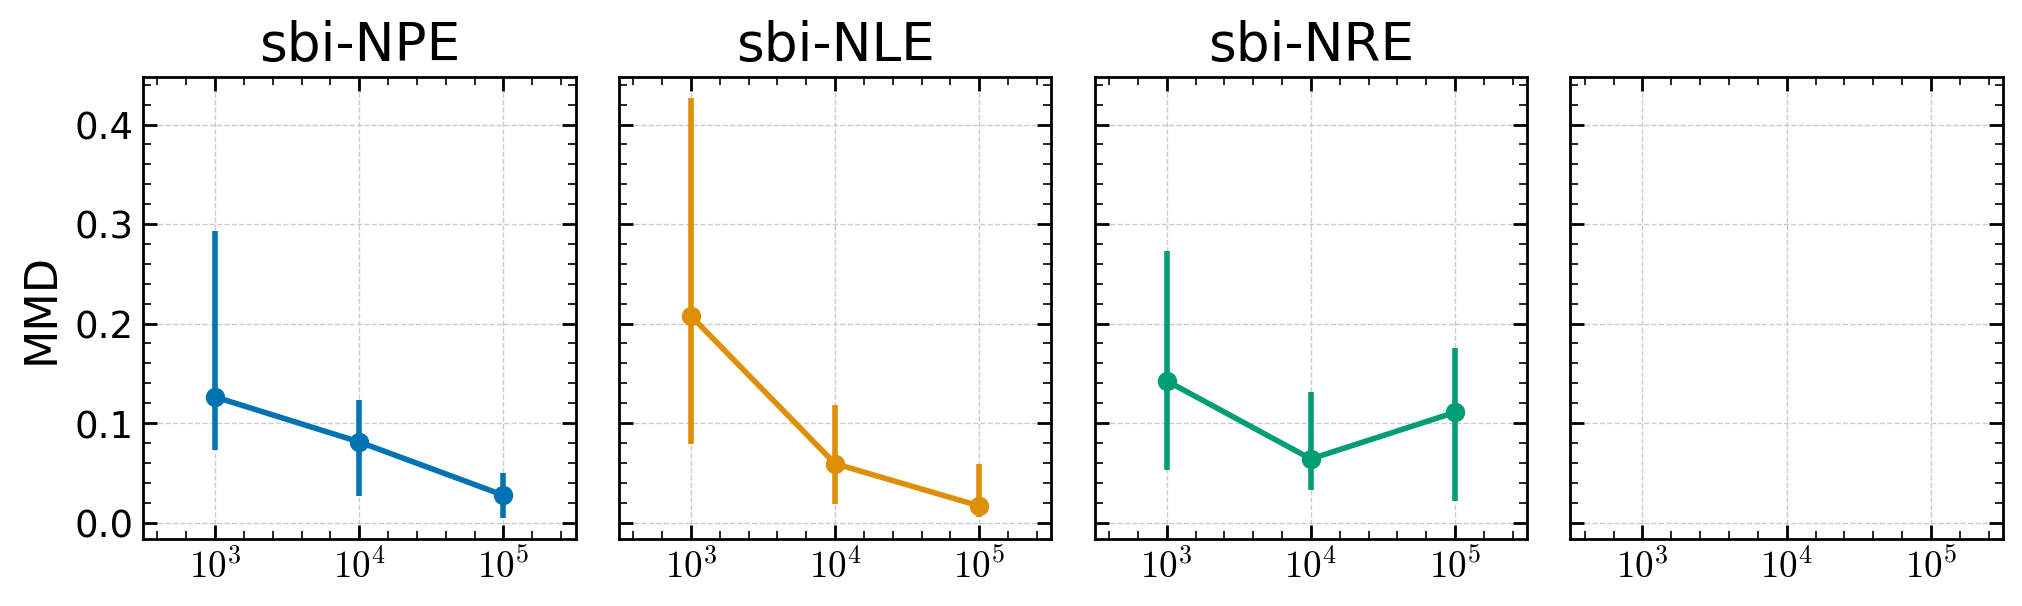

In [41]:
from math import ceil

keys = ['npe', 'nle', 'nre']
names = ['sbi-NPE', 'sbi-NLE', 'sbi-NRE']
cs = sns.color_palette('colorblind', n_colors=len(keys))

N = len(keys)
Ncol = 4
Nrow = ceil(N/Ncol)
f, axs = plt.subplots(Nrow, Ncol, figsize=(Ncol*3, Nrow*3),
                      sharex=True, sharey=True, gridspec_kw={'hspace':0.1, 'wspace':0.1})
axs = axs.flatten()

for i, m in enumerate(keys):
    ax = axs[i]
    p = np.stack(percs.loc[m].values)
    ax.errorbar(
        x=range(len(p)),
        y=p[:,1],
        yerr=[p[:,1]-p[:,0], p[:,2]-p[:,1]],
        fmt='o-',
        color=cs[i],
    )
    ax.set_title(names[i])
    ax.set_xlim(-0.5, 2.5)
    ax.set_xticks(range(3), [f"$10^{i}$" for i in range(3,6)])
    
    if i%Ncol == 0:
        ax.set_ylabel('MMD')

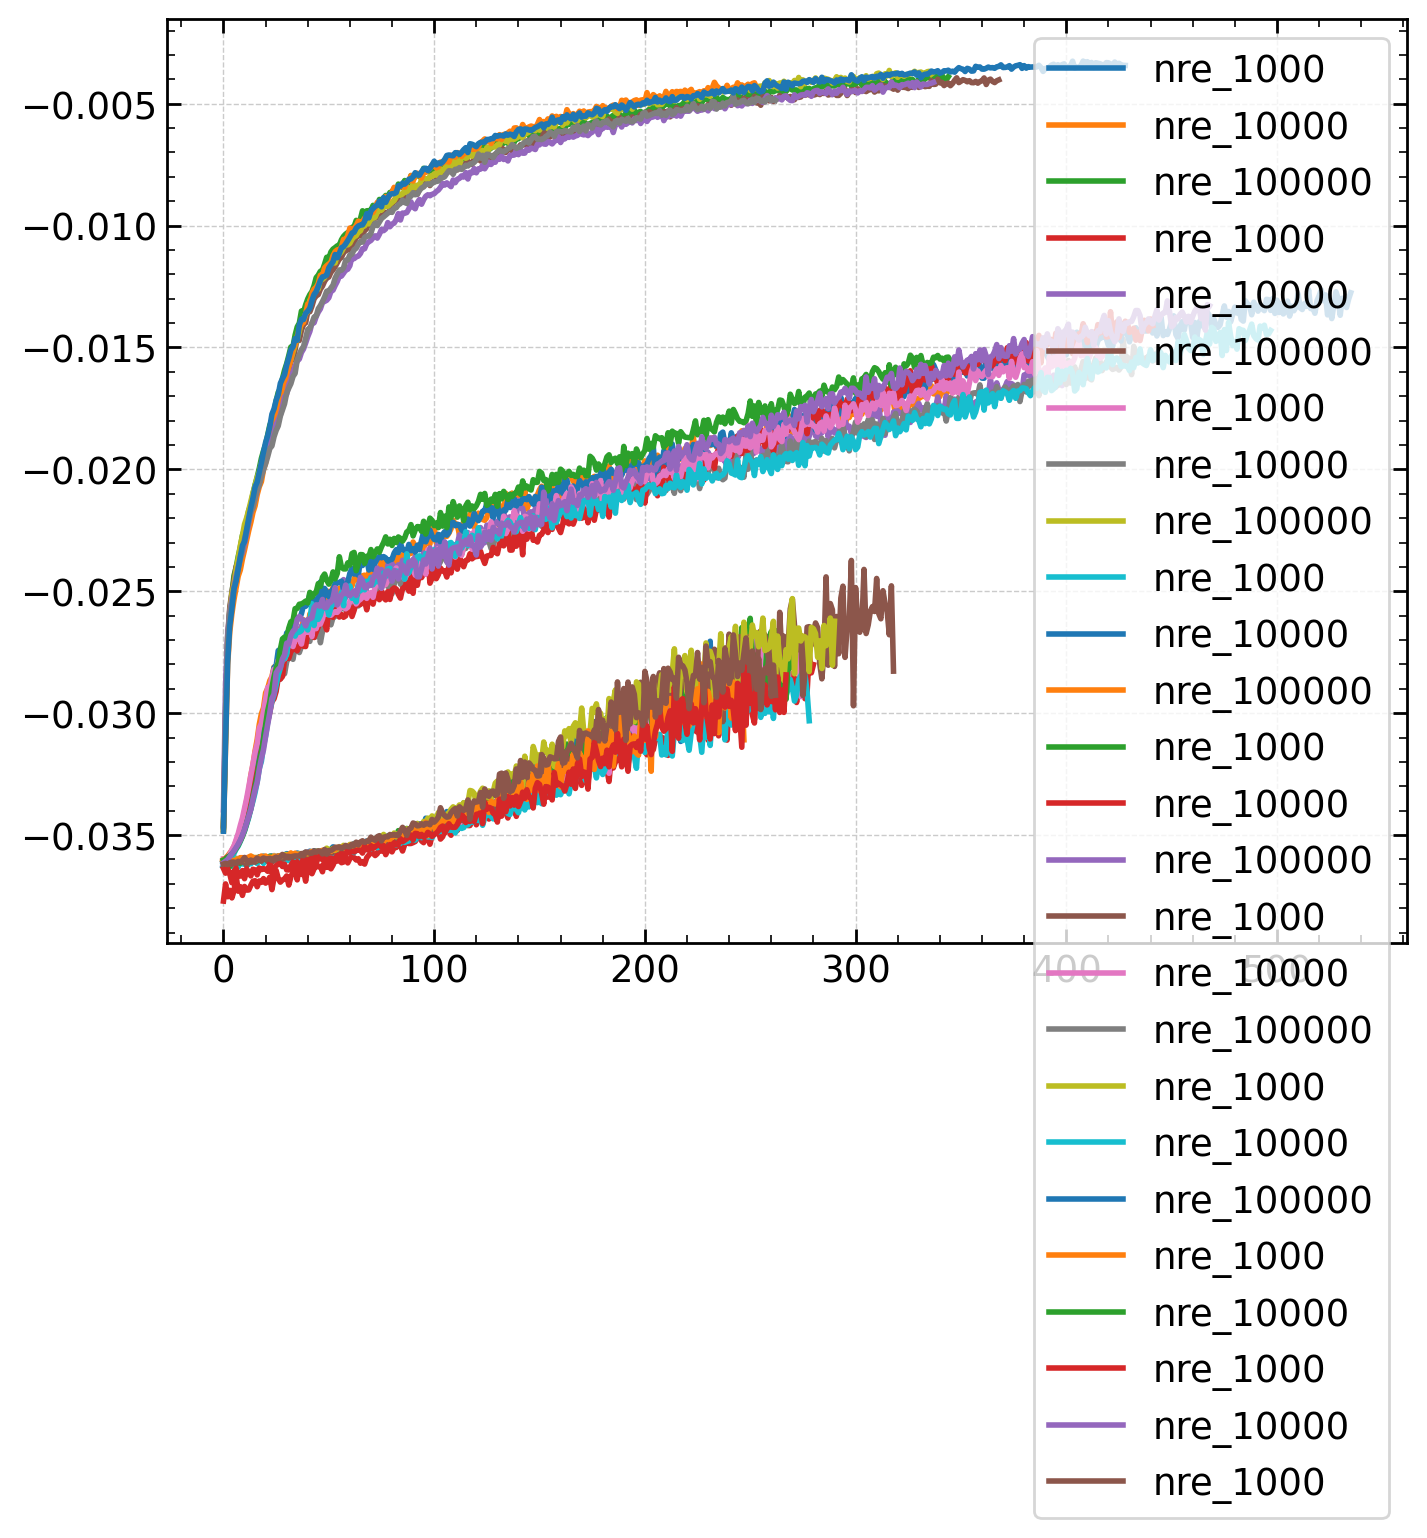

In [42]:
import json 

model = 'nre'
for i, row in record.iterrows():
    if not row['done']:
        continue
    if row['model'] != model:
        continue
    summ =  json.load(open(join(row['dir'], 'summary.json')))[0]
    val_loss = summ['validation_log_probs']

    plt.plot(val_loss, label=f"{row['model']}_{row['N']}")
plt.legend()

# Scratch